# COVID-19 Detection - VGG16 Model

#### Import the required libraries

In [14]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import keras
from keras import optimizers, callbacks
from keras.layers import Flatten, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import zipfile
import warnings
warnings.filterwarnings("ignore")

#### Download and unzip the dataset

In [ ]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

Dataset URL: https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset
License(s): CC-BY-NC-SA-4.0
sarscov2-ctscan-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_ref = zipfile.ZipFile('/content/sarscov2-ctscan-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

#### Data loading and preprocessing

In [15]:
disease_types = ['COVID', 'non-COVID']
data_dir = '/content'
train_data = []

In [16]:
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append([f'{sp}/{file}', defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])

In [17]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

#### Prepare and normalize data

In [18]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

2481it [00:18, 132.98it/s]


In [19]:
X_train = X_train.astype('float32') / 255.0
Y_train = to_categorical(train['DiseaseID'].values, num_classes=2)

#### Split the dataset into train and test sets

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#### Model architecture

In [21]:
def build_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=1e-3)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    model.summary()

    return model

#### Model and callbacks creation

In [22]:
model = build_model()

callbacks = [
    ModelCheckpoint(
        'vgg16_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-5
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,695,170 (105.65 MB)

 Trainable params: 12,978,946 (49.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

#### Model training

In [23]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=15,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - accuracy: 0.7092 - loss: 0.8248 - val_accuracy: 0.8793 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.8204 - loss: 0.4464 - val_accuracy: 0.9095 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 386ms/step - accuracy: 0.8464 - loss: 0.3840 - val_accuracy: 0.8692 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 400ms/step - accuracy: 0.8687 - loss: 0.3106 - val_accuracy: 0.8974 - val_loss: 0.2356 - learning_rate: 0.0010
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 405ms/step - accuracy: 0.8784 - loss: 0.3099 - val_accuracy: 0.9256 - val_loss: 0.1771 - learning_rate: 0.0010
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.8957 - loss: 0.2514 - val_accuracy: 0.9316 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.9066 - loss: 0.

#### Model evaluation

In [25]:
model.load_weights("vgg16_model.keras")
score = model.evaluate(X_val, Y_val, verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9694 - loss: 0.0825
Test Loss: 0.10102921724319458
Test accuracy: 0.9637826681137085


In [26]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_val, axis=1)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=disease_types))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step
Classification Report:
              precision    recall  f1-score   support

       COVID       0.96      0.97      0.96       239
   non-COVID       0.97      0.96      0.96       258

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


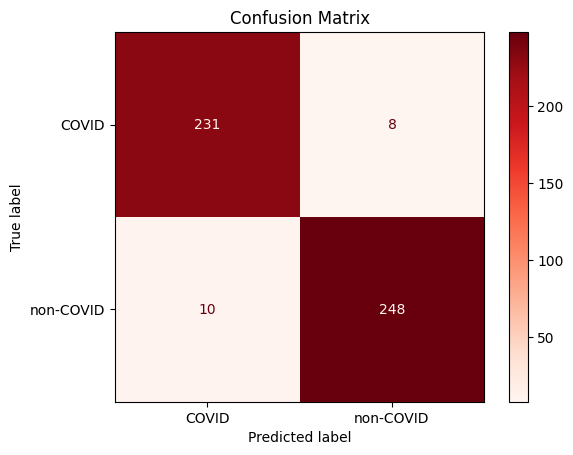

In [27]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis=-1)
Y_testx = np.argmax(Y_val, axis=-1)
cf_matrix = confusion_matrix(Y_testx, Y_predx)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['COVID', 'non-COVID'])
disp.plot(cmap='Reds')
plt.title("Confusion Matrix")
plt.show()

#### Visualizing accuracy and loss over epochs

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

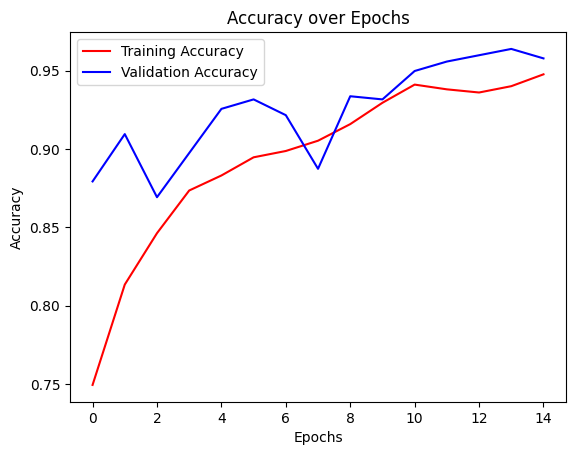

In [29]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

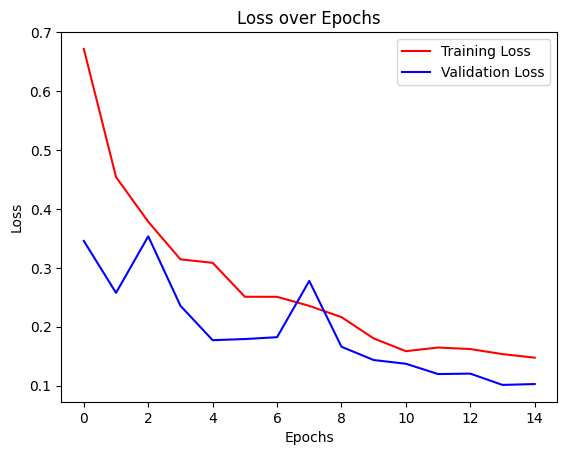

In [30]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [33]:
def predict_image(image_path, model, target_size=(224, 224), display_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)

    disease_types = ['COVID', 'non-COVID']
    predicted_disease = disease_types[predicted_class[0]]
    confidence = np.max(prediction)

    img_original = cv2.imread(image_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_original, display_size, interpolation=cv2.INTER_LINEAR)

    plt.imshow(img_resized)
    plt.title(f"Predicted Disease: {predicted_disease}\nConfidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()

    return predicted_disease, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


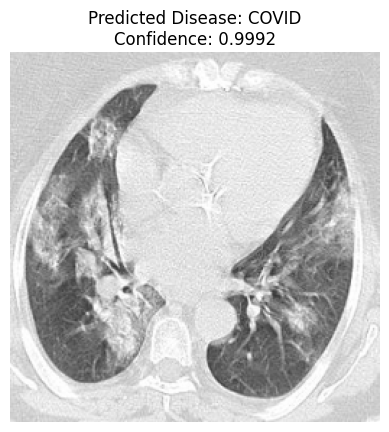

In [34]:
image_path = '/content/COVID/Covid (1007).png'
disease, confidence = predict_image(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


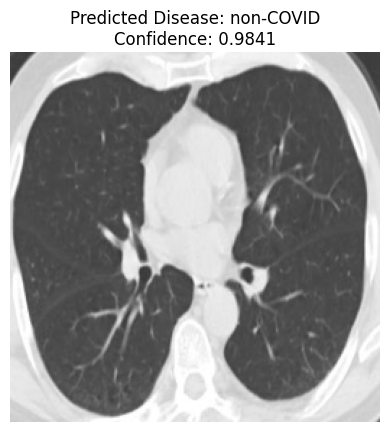

In [35]:
image_path = '/content/non-COVID/Non-Covid (1007).png'
disease, confidence = predict_image(image_path, model)